0:	learn: 0.6835953	test: 0.6630303	best: 0.6630303 (0)	total: 207ms	remaining: 3m 27s
200:	learn: 0.9971425	test: 0.6606061	best: 0.6806061 (57)	total: 6.8s	remaining: 27s
400:	learn: 1.0000000	test: 0.6651515	best: 0.6806061 (57)	total: 13.8s	remaining: 20.6s
600:	learn: 1.0000000	test: 0.6615152	best: 0.6806061 (57)	total: 20.7s	remaining: 13.7s
800:	learn: 1.0000000	test: 0.6648485	best: 0.6806061 (57)	total: 27.7s	remaining: 6.89s
999:	learn: 1.0000000	test: 0.6627273	best: 0.6806061 (57)	total: 34.6s	remaining: 0us

bestTest = 0.6806060606
bestIteration = 57

Shrink model to first 58 iterations.
Accuracy: 0.6806060606060607
              precision    recall  f1-score   support

           0       0.57      0.83      0.67      1312
           1       0.84      0.58      0.69      1988

    accuracy                           0.68      3300
   macro avg       0.70      0.71      0.68      3300
weighted avg       0.73      0.68      0.68      3300



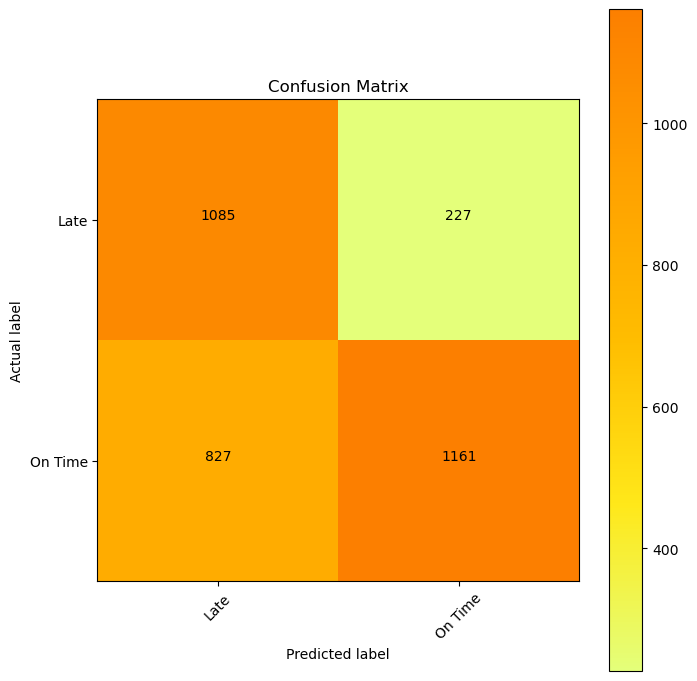

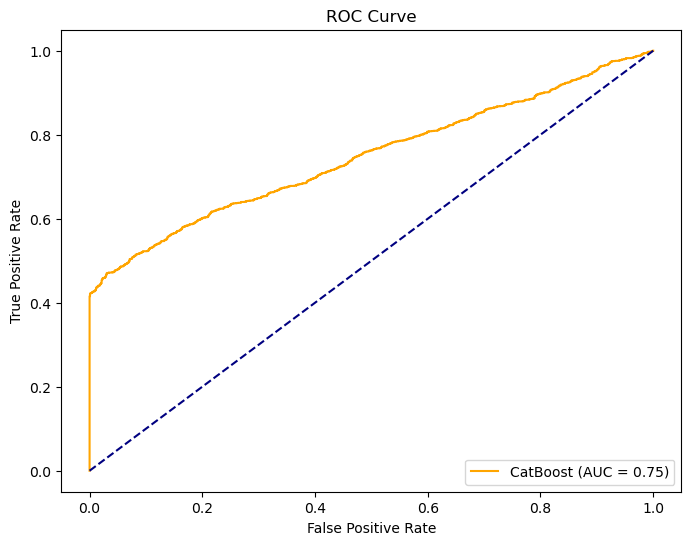

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import itertools

# Load the dataset
df = pd.read_csv("C:/Users/anoop/Downloads/Train new.csv")

# Function to categorize discount into ranges
def categorize_discount(discount):
    if 0 <= discount <= 5:
        return 'Low'
    elif 5 < discount <= 20:
        return 'Medium'
    elif 20 < discount <= 100:
        return 'High'
    else:
        return 'Undefined'

# Function to categorize weight into ranges
def categorize_weight(weight):
    if 0 <= weight <= 1899:
        return 'Low'
    elif 1900 <= weight <= 4199:
        return 'Medium'
    elif 4200 <= weight <= 9000:
        return 'High'
    else:
        return 'Undefined'

df['Discount_Range'] = df['Discount_offered'].apply(categorize_discount)
df['Weight_Range'] = df['Weight_in_gms'].apply(categorize_weight)

# Dropping the 'ID' column
df = df.drop(['ID'], axis=1)

# Splitting the dataset into features and target variable
X = df.drop(['Reached.on.Time_Y.N'], axis=1)
y = df['Reached.on.Time_Y.N']

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# CatBoost needs to know which features are categorical (by their indices)
categorical_features_indices = np.where(X_train.dtypes != float)[0]

# Initialize CatBoostClassifier
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=10,
    loss_function='Logloss',
    eval_metric='Accuracy',
    random_seed=42,
    verbose=200,
    cat_features=categorical_features_indices
)

# Fit model
model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# Predicting
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Late', 'On Time'], rotation=45)
plt.yticks(tick_marks, ['Late', 'On Time'])
plt.tight_layout()
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="black")

plt.show()

# ROC Curve and AUC (using probabilities for the positive class)
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f'CatBoost (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


Best Accuracy: 0.6627272727272727
              precision    recall  f1-score   support

           0       0.56      0.76      0.64      1312
           1       0.79      0.60      0.68      1988

    accuracy                           0.66      3300
   macro avg       0.67      0.68      0.66      3300
weighted avg       0.70      0.66      0.67      3300



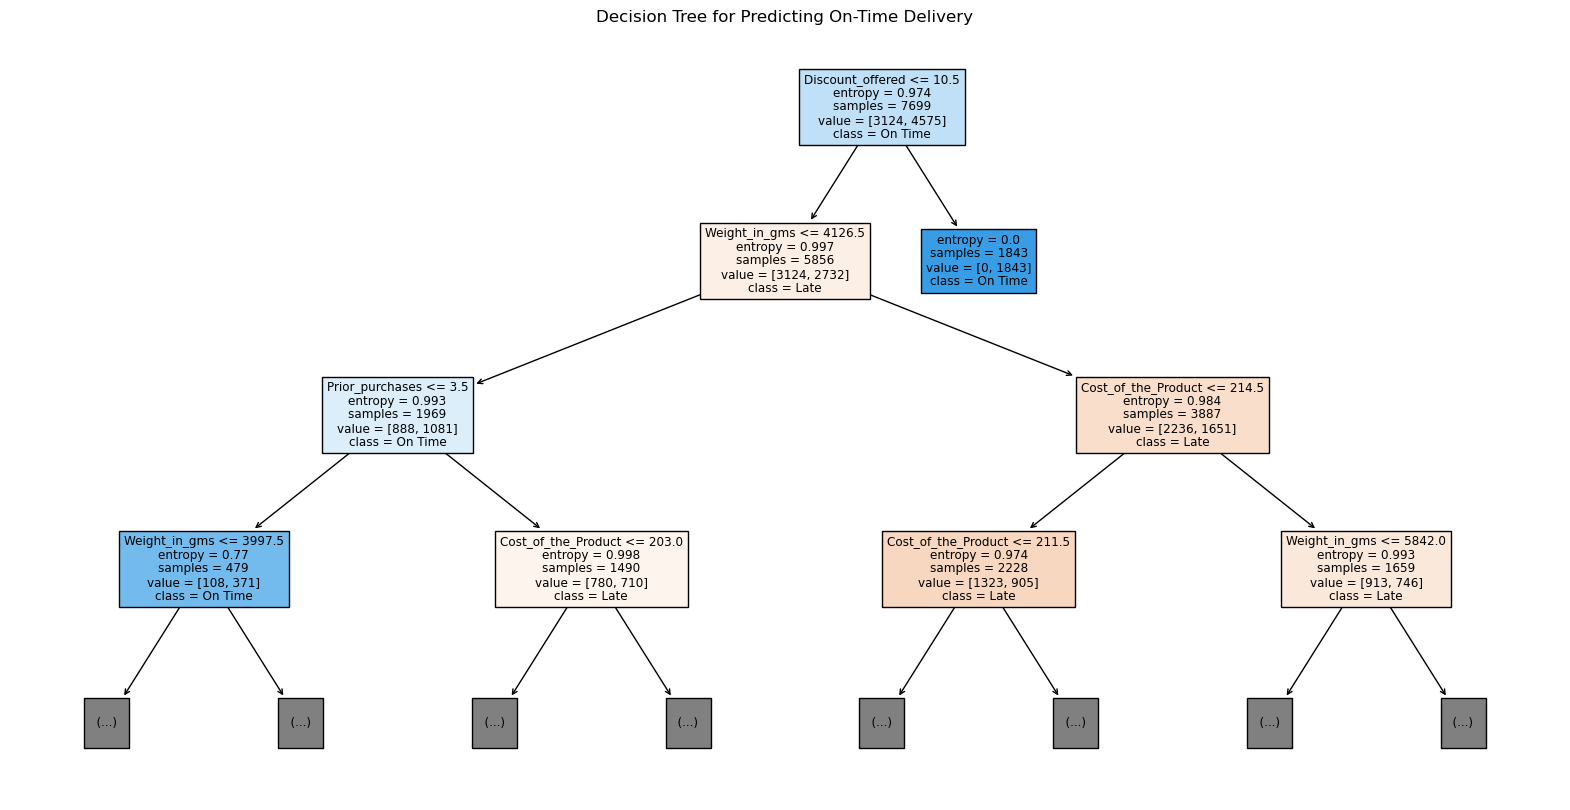

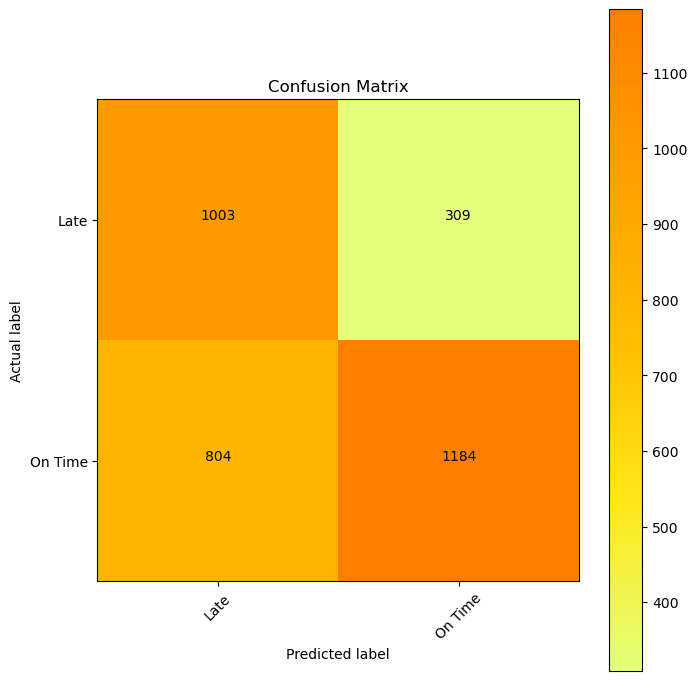

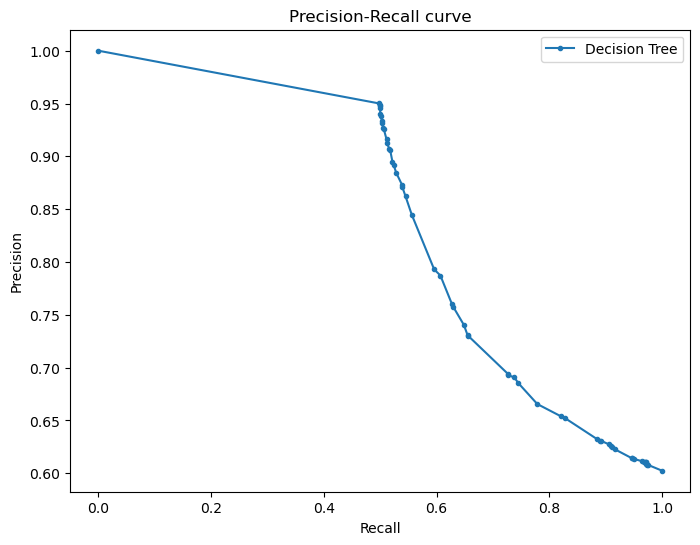

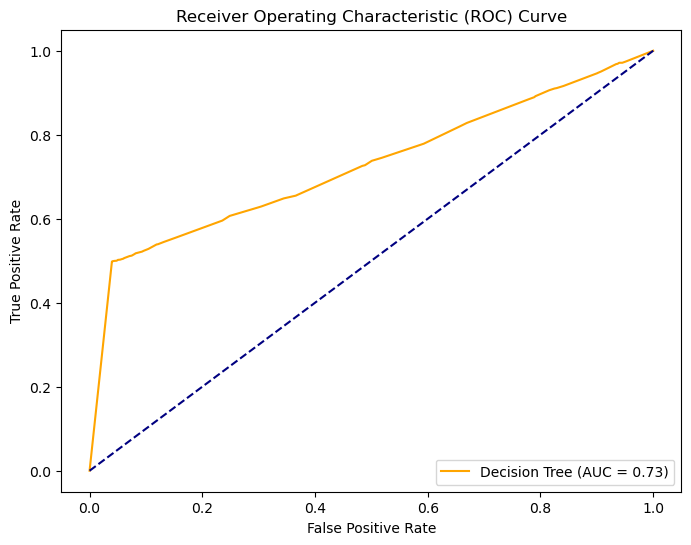

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             precision_recall_curve, roc_curve, auc)
import itertools

# Load the dataset
df = pd.read_csv("C:/Users/anoop/Downloads/Train new.csv")

# Function to categorize discount into ranges
def categorize_discount(discount):
    if 0 <= discount <= 5:
        return 'Low'
    elif 5 < discount <= 20:
        return 'Medium'
    elif 20 < discount <= 100:
        return 'High'
    else:
        return 'Undefined'

# Function to categorize weight into ranges
def categorize_weight(weight):
    if 0 <= weight <= 1899:
        return 'Low'
    elif 1900 <= weight <= 4199:
        return 'Medium'
    elif 4200 <= weight <= 9000:
        return 'High'
    else:
        return 'Undefined'

df['Discount_Range'] = df['Discount_offered'].apply(categorize_discount)
df['Weight_Range'] = df['Weight_in_gms'].apply(categorize_weight)

# Dropping the 'ID' column and converting categorical variables into numeric using one-hot encoding
df_model = df.drop(['ID'], axis=1)
categorical_cols = df_model.select_dtypes(include=['object']).columns
df_model = pd.get_dummies(df_model, columns=categorical_cols)

# Splitting the dataset into features and target variable
X = df_model.drop(['Reached.on.Time_Y.N'], axis=1)
y = df_model['Reached.on.Time_Y.N']

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Hyperparameter tuning setup
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'criterion': ['gini', 'entropy']
}

# Grid search with cross-validation
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best estimator
best_clf = grid_search.best_estimator_

# Predicting and evaluating
y_pred_best = best_clf.predict(X_test)
y_pred_proba_best = best_clf.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
best_accuracy = accuracy_score(y_test, y_pred_best)
print(f"Best Accuracy: {best_accuracy}")
print(classification_report(y_test, y_pred_best))

# Visualizing the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(best_clf, filled=True, feature_names=X.columns, class_names=['Late', 'On Time'], max_depth=3)
plt.title('Decision Tree for Predicting On-Time Delivery')
plt.show()

# Plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(7, 7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Late', 'On Time'], rotation=45)
plt.yticks(tick_marks, ['Late', 'On Time'])
plt.tight_layout()
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="black")

plt.show()

# Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_best)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Decision Tree')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

# ROC curve and AUC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba_best)
roc_auc = auc(fpr, tpr)  # Compute AUC score

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f'Decision Tree (AUC = {roc_auc:.2f})')  # Include AUC in the label
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Best Accuracy: 0.6836363636363636
              precision    recall  f1-score   support

           0       0.57      0.86      0.68      1312
           1       0.86      0.57      0.68      1988

    accuracy                           0.68      3300
   macro avg       0.71      0.71      0.68      3300
weighted avg       0.74      0.68      0.68      3300



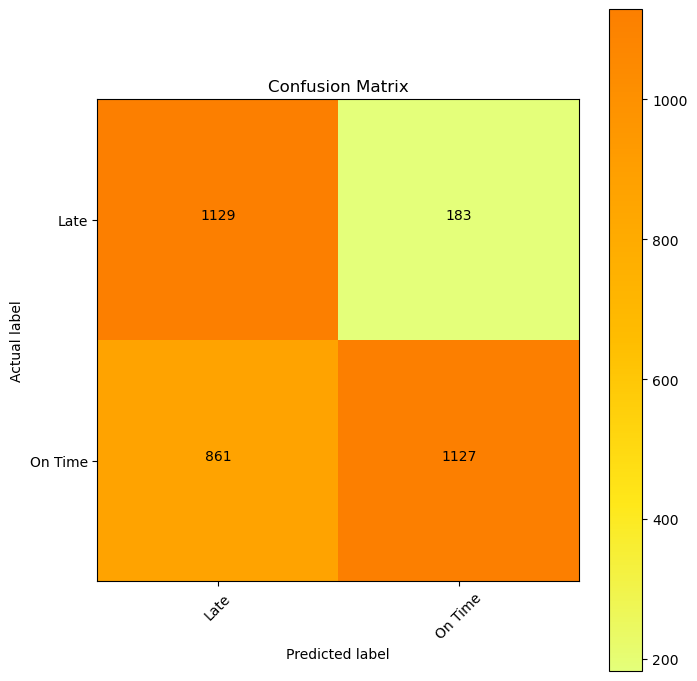

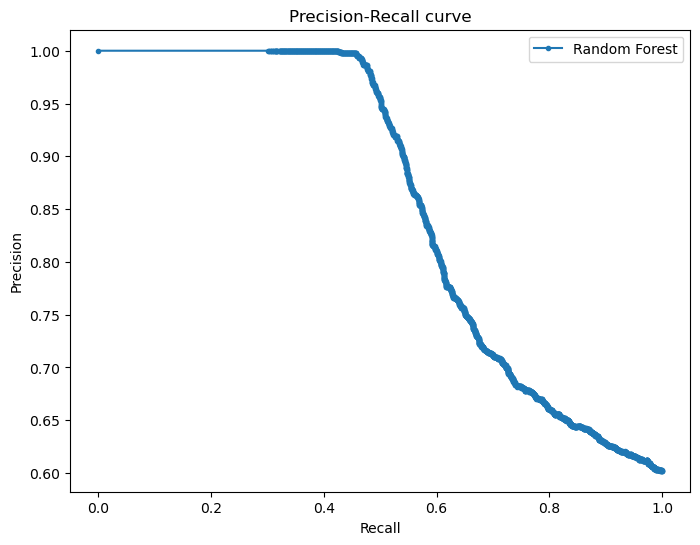

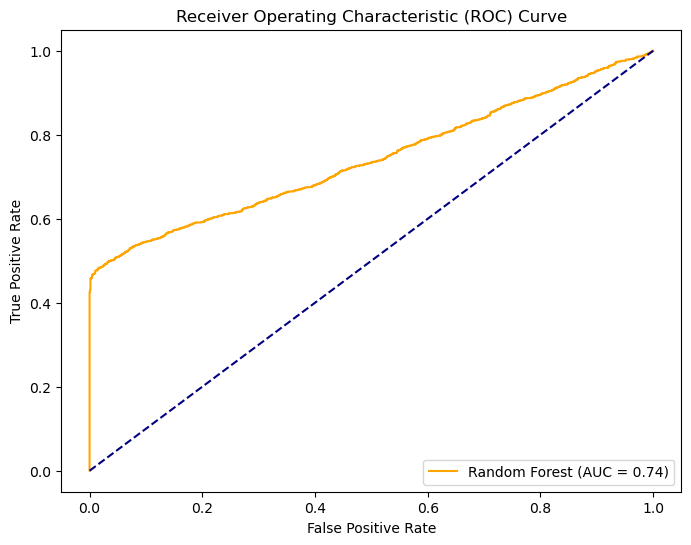

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             precision_recall_curve, roc_curve, auc)
import itertools

# Load the dataset
df = pd.read_csv("C:/Users/anoop/Downloads/Train new.csv")

# Function to categorize discount into ranges
def categorize_discount(discount):
    if 0 <= discount <= 5:
        return 'Low'
    elif 5 < discount <= 20:
        return 'Medium'
    elif 20 < discount <= 100:
        return 'High'
    else:
        return 'Undefined'

# Function to categorize weight into ranges
def categorize_weight(weight):
    if 0 <= weight <= 1899:
        return 'Low'
    elif 1900 <= weight <= 4199:
        return 'Medium'
    elif 4200 <= weight <= 9000:
        return 'High'
    else:
        return 'Undefined'

df['Discount_Range'] = df['Discount_offered'].apply(categorize_discount)
df['Weight_Range'] = df['Weight_in_gms'].apply(categorize_weight)

# Dropping the 'ID' column and converting categorical variables into numeric using one-hot encoding
df_model = df.drop(['ID'], axis=1)
categorical_cols = df_model.select_dtypes(include=['object']).columns
df_model = pd.get_dummies(df_model, columns=categorical_cols)

# Splitting the dataset into features and target variable
X = df_model.drop(['Reached.on.Time_Y.N'], axis=1)
y = df_model['Reached.on.Time_Y.N']

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Hyperparameter tuning setup for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'criterion': ['gini', 'entropy']
}

# Grid search with cross-validation for Random Forest
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best estimator for Random Forest
best_clf = grid_search.best_estimator_

# Predicting and evaluating for Random Forest
y_pred_best = best_clf.predict(X_test)
y_pred_proba_best = best_clf.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
best_accuracy = accuracy_score(y_test, y_pred_best)
print(f"Best Accuracy: {best_accuracy}")
print(classification_report(y_test, y_pred_best))

# Plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(7, 7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Late', 'On Time'], rotation=45)
plt.yticks(tick_marks, ['Late', 'On Time'])
plt.tight_layout()
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="black")
plt.show()

# Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_best)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

# ROC curve and AUC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba_best)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Best Accuracy: 0.6842424242424242
              precision    recall  f1-score   support

           0       0.56      0.93      0.70      1312
           1       0.92      0.52      0.66      1988

    accuracy                           0.68      3300
   macro avg       0.74      0.73      0.68      3300
weighted avg       0.78      0.68      0.68      3300



<Figure size 1000x800 with 0 Axes>

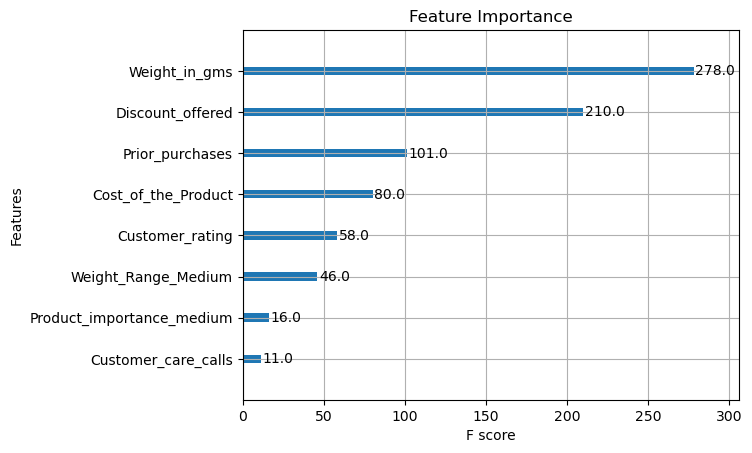

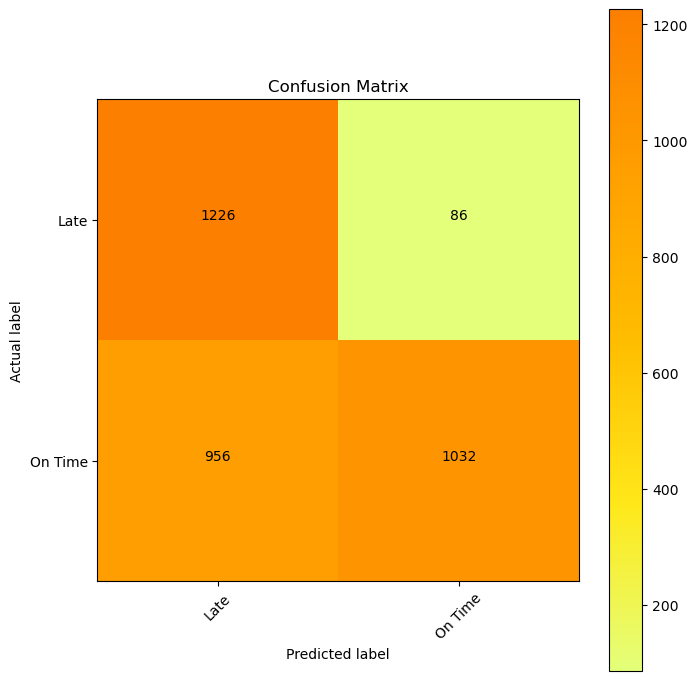

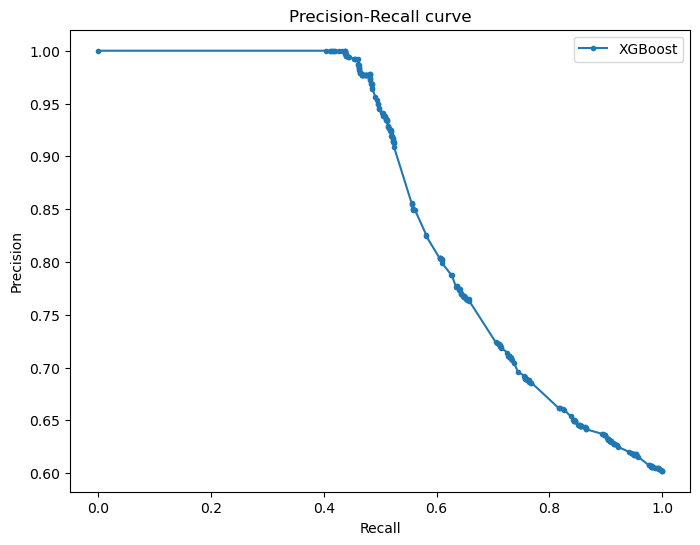

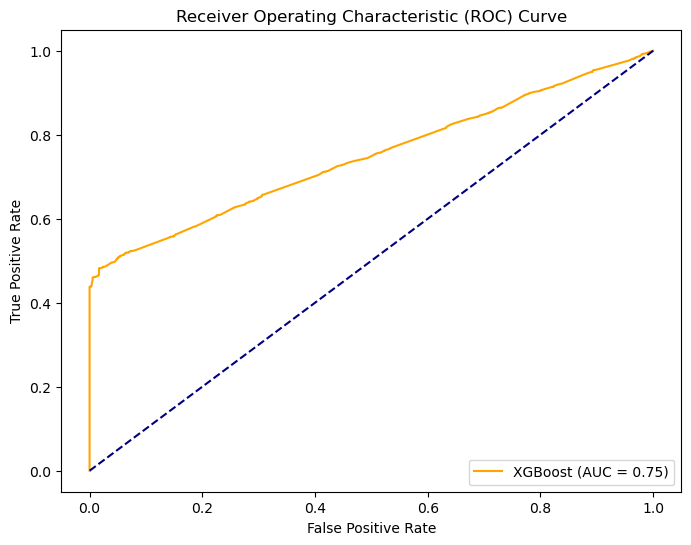

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
from xgboost import XGBClassifier, plot_importance
import itertools

# Load the dataset
df = pd.read_csv("C:/Users/anoop/Downloads/Train new.csv")

# Function to categorize discount into ranges
def categorize_discount(discount):
    if 0 <= discount <= 5:
        return 'Low'
    elif 5 < discount <= 20:
        return 'Medium'
    elif 20 < discount <= 100:
        return 'High'
    else:
        return 'Undefined'

# Function to categorize weight into ranges
def categorize_weight(weight):
    if 0 <= weight <= 1899:
        return 'Low'
    elif 1900 <= weight <= 4199:
        return 'Medium'
    elif 4200 <= weight <= 9000:
        return 'High'
    else:
        return 'Undefined'

df['Discount_Range'] = df['Discount_offered'].apply(categorize_discount)
df['Weight_Range'] = df['Weight_in_gms'].apply(categorize_weight)

# Dropping the 'ID' column and converting categorical variables into numeric using one-hot encoding
df_model = df.drop(['ID'], axis=1)
categorical_cols = df_model.select_dtypes(include=['object']).columns
df_model = pd.get_dummies(df_model, columns=categorical_cols)

# Splitting the dataset into features and target variable
X = df_model.drop(['Reached.on.Time_Y.N'], axis=1)
y = df_model['Reached.on.Time_Y.N']

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Hyperparameter tuning setup for XGBoost
param_grid = {
    'max_depth': [3, 6, 10],
    'min_child_weight': [1, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0]
}

# Grid search with cross-validation
grid_search = GridSearchCV(XGBClassifier(eval_metric='logloss', random_state=42), 
                           param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best estimator
best_clf = grid_search.best_estimator_

# Predicting and evaluating
y_pred_best = best_clf.predict(X_test)
y_pred_proba_best = best_clf.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
best_accuracy = accuracy_score(y_test, y_pred_best)
print(f"Best Accuracy: {best_accuracy}")
print(classification_report(y_test, y_pred_best))

# Feature importance visualization
plt.figure(figsize=(10, 8))
plot_importance(best_clf, max_num_features=10)  # Shows the top 10 most important features
plt.title('Feature Importance')
plt.show()

# Plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(7, 7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Late', 'On Time'], rotation=45)
plt.yticks(tick_marks, ['Late', 'On Time'])
plt.tight_layout()
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="black")

plt.show()

# Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_best)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='XGBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

# ROC curve and AUC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba_best)
roc_auc = auc(fpr, tpr)  # Compute AUC score

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f'XGBoost (AUC = {roc_auc:.2f})')  # Include AUC in the label
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()